# 04 – Probabilistic forecasts (1hr ahead)

This notebook extends point forecasting to probabilistic forecasting for German electricity load.  
We compare two practical approaches:

- Quantile regression that directly predicts conditional quantiles like q=0.1, 0.5, 0.9
- Conformal prediction intervals that wraps a point model with statistically-valid uncertainty bands

We evaluate:
- Coverage: how often the true value falls inside the prediction interval
- Width / sharpness: average interval size (narrower is better at comparable coverage)
- Point error: MAE/RMSE from the point estimate (median for quantiles, model prediction for conformal)
- Calibration: whether predicted quantiles behave like their nominal probabilities
- Pinball loss: reported for q ∈ {0.1, 0.5, 0.9} and as an average (lower is better).
- Stress tests: extremes, peak week, hour-of-day diagnostics

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


from src.data import load_opsd_germany
from src.features import make_features
from src.models import train_point_model, train_quantile_models, predict_quantiles
from src.conformal import compute_absolute_residuals, conformal_interval
from src.evaluation import (
    regression_metrics,
    interval_coverage,
    interval_width,
    quantile_calibration,
    plot_quantile_calibration,
    pinball_loss,
)

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True

### Data and leakage-safe splits

Time series forecasting has a common pitfall: leakage from the future into the past.

To avoid that, we create chronological train/calibration/test splits:
- Train (60%): fit models
- Calibration (20%): estimate uncertainty (conformal residual quantiles)
- Test (20%): final evaluation only

We first build supervised features for 1-hour-ahead forecasting.



In [ ]:
raw = load_opsd_germany(str(PROJECT_ROOT / "data" / "time_series_60min_singleindex.csv"))
X, y = make_features(raw, horizon=1, target_col="load")

# 60/20/20 split by time index
n = len(X)
cutoff_train = X.index[int(0.6 * n)]
cutoff_cal = X.index[int(0.8 * n)]

X_train = X[X.index < cutoff_train]
y_train = y[y.index < cutoff_train]

X_cal = X[(X.index >= cutoff_train) & (X.index < cutoff_cal)]
y_cal = y[(y.index >= cutoff_train) & (y.index < cutoff_cal)]

X_test = X[X.index >= cutoff_cal]
y_test = y[X.index >= cutoff_cal]

X_train.shape, X_cal.shape, X_test.shape


((29958, 28), (9986, 28), (9986, 28))

## Method 1 - Quantile regression for prediction intervals

Quantile regression predicts conditional quantiles of the target distribution given features.
Instead of a single forecast, we directly estimate:

- q=0.1: a lower bound
- q=0.5: median forecast (a robust point estimate)
- q=0.9: an upper bound

The interval [q0.1, q0.9] is an 80% predictive interval if the model is calibrated.


In [ ]:
quantiles = [0.1, 0.5, 0.9]
q_models = train_quantile_models(X_train, y_train, quantiles=quantiles)
q_preds_test = predict_quantiles(q_models, X_test)
q_preds_test.head()


,q_0.1,q_0.5,q_0.9
utc_timestamp,,,
2019-08-11 21:00:00+00:00,39454.867008,40511.196433,42263.213012
2019-08-11 22:00:00+00:00,38136.997914,38900.165161,40040.052083
2019-08-11 23:00:00+00:00,36986.692763,38033.753090,38730.343768
2019-08-12 00:00:00+00:00,37868.351413,38610.258461,39186.831669
2019-08-12 01:00:00+00:00,38729.861230,38850.220642,39668.434422


We now have time-indexed predictions for each quantile. Next we evaluate
1. Coverage of the 80% interval (should be close to 0.80)
2. Average interval width (sharpness)
3. Median point accuracy via MAE/RMSE



In [4]:
lower_q = q_preds_test["q_0.1"].values
upper_q = q_preds_test["q_0.9"].values
median_q = q_preds_test["q_0.5"].values

coverage_q = interval_coverage(y_test, lower_q, upper_q)
width_q = interval_width(lower_q, upper_q)
point_metrics_q = regression_metrics(y_test, median_q)

coverage_q, width_q, point_metrics_q


(0.7792910074103745,
 2504.423594775794,
 {'MAE': 685.153112981041, 'RMSE': 965.947009884587})

### Visual inspection

Aggregate metrics can hide local failures. Plotting a short time window lets us see:
- undercoverage during sharp peaks / ramps (interval too narrow)
- overly conservative bands in flat periods (interval too wide)

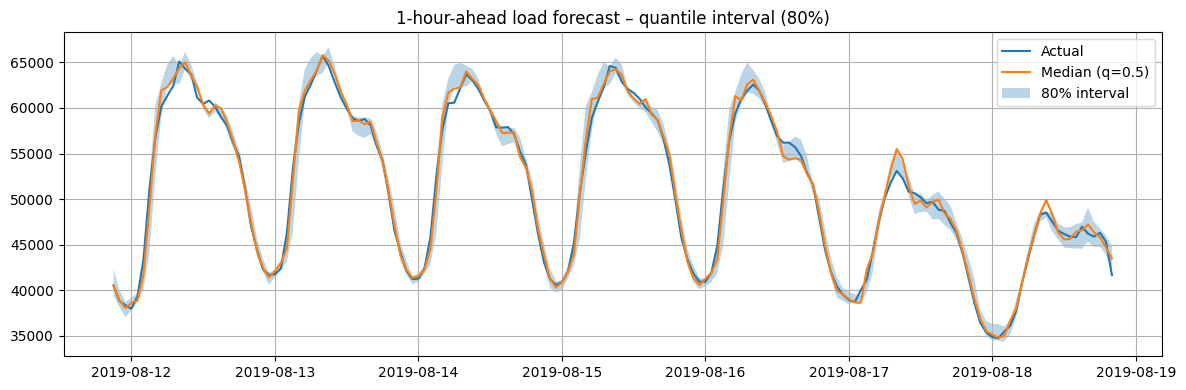

In [ ]:
sample = slice(0, 7 * 24)
time = y_test.index[sample]

plt.plot(time, y_test.values[sample], label="Actual", linewidth=1.5)
plt.plot(time, median_q[sample], label="Median (q=0.5)")
plt.fill_between(time, lower_q[sample], upper_q[sample], alpha=0.3, label="80% interval")

plt.title("1-hour-ahead load forecast – quantile interval (80%)")
plt.legend()
plt.tight_layout()
plt.show()


The observed series seems to repeatedly fall outside the band near peaks,
that indicates local miscalibration even if average coverage looks acceptable.


### Quantile calibration

A calibrated quantile model satisfies:

$$ P(Y ≤ q̂(x)) ≈ q$$

We estimate the empirical frequency that the true value falls below each predicted quantile,
and compare it to the nominal quantile level. Perfect calibration lies on the 45° line.


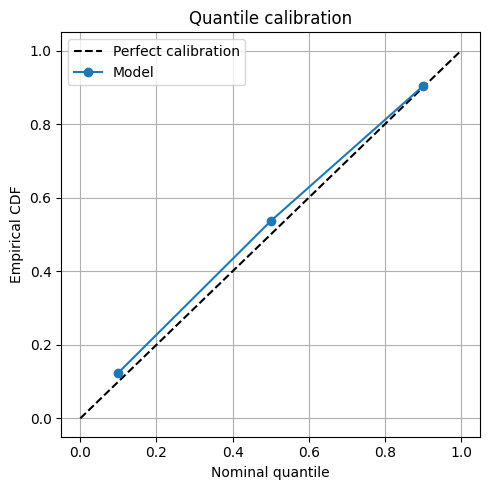

In [ ]:
calib_df = quantile_calibration(
    y_true=y_test.values,
    q_pred_dict={
        0.1: q_preds_test["q_0.1"].values,
        0.5: q_preds_test["q_0.5"].values,
        0.9: q_preds_test["q_0.9"].values,
    },
)
calib_df
plot_quantile_calibration(calib_df)


In our plot, the model is close to calibrated overall, with mild upward bias near the median.

## Method 2 - Conformal prediction intervals (distribution-free uncertainty)

Conformal prediction wraps a point model to produce uncertainty intervals with finite-sample guarantees
under exchangeability (often a reasonable approximation for many forecasting pipelines).

We will: 
1. Train a point model on the training set  
2. Compute absolute residuals on the calibration set  
3. Use the (1-α) residual quantile to create a (1-α) interval on test data  

Here we target 90% coverage with α = 0.1.


In [ ]:
point_model = train_point_model(X_train, y_train)
residuals = compute_absolute_residuals(point_model, X_cal, y_cal)
np.quantile(residuals, [0.5, 0.8, 0.9, 0.95])


array([ 463.10774284,  956.29820477, 1299.02289534, 1688.1373201 ])

The calibration residual quantiles summarize typical error magnitude.
For basic conformal, the resulting test-time band is approximately:

$$ \text{point forecast}  ± q_{1-α}(|\text{residual}|)$$

#### Building a 90% conformal interval

We set α = 0.1, targeting 90% coverage.
Conformal intervals are usually wider than an 80% quantile band,
but aim to be reliably calibrated given the calibration residuals.


In [ ]:
alpha = 0.1 
lower_conf, upper_conf = conformal_interval(model=point_model, X=X_test, residuals=residuals, alpha=alpha)
y_pred_point_test = point_model.predict(X_test)

coverage_conf = interval_coverage(y_test, lower_conf, upper_conf)
width_conf = interval_width(lower_conf, upper_conf)
point_metrics_conf = regression_metrics(y_test, y_pred_point_test)

coverage_conf, width_conf, point_metrics_conf


(0.8638093330662928,
 2598.045790686476,
 {'MAE': 674.907649951304, 'RMSE': 905.598981028686})

## Summary: quantile vs conformal 

In [ ]:
results = pd.DataFrame({
    "method": ["quantile_80", "conformal_90"],
    "coverage": [coverage_q, coverage_conf],
    "avg_width": [width_q, width_conf],
    "MAE": [point_metrics_q["MAE"], point_metrics_conf["MAE"]],
    "RMSE": [point_metrics_q["RMSE"], point_metrics_conf["RMSE"]],
})
results


,method,coverage,avg_width,MAE,RMSE
0,quantile_80,0.779291,2504.423595,685.153113,965.947010
1,conformal_90,0.863809,2598.045791,674.907650,905.598981


Interpretation:
- Conformal tends to be more conservative (wider) but often closer to its coverage target
- Quantile intervals may be sharper but can under-cover in difficult regions (e.g., extremes)


### Visual check: conformal band
We plot the point forecast and the 90% conformal band to inspect whether uncertainty expands around unusual ramps.
Basic conformal often yields nearly constant width, since it uses a single global residual quantile.

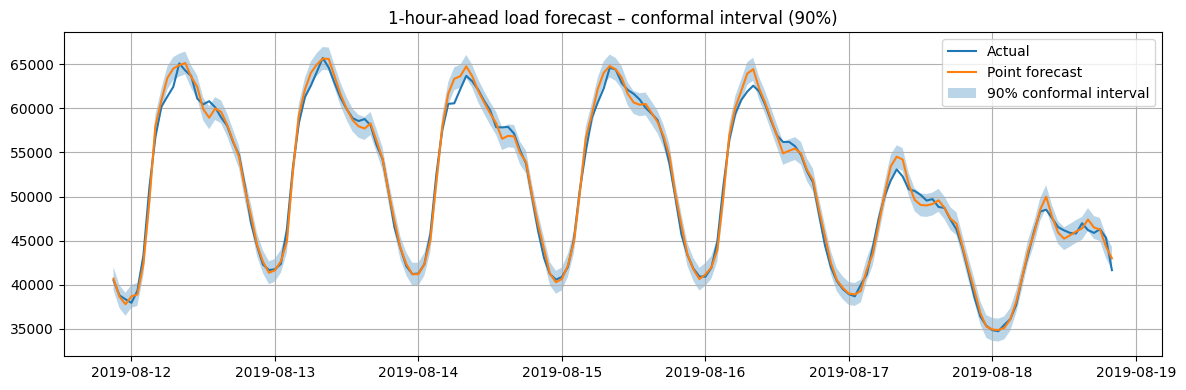

In [10]:
# Plot conformal band for a sample week
sample = slice(0, 7 * 24)
time = y_test.index[sample]

plt.plot(time, y_test.values[sample], label="Actual", linewidth=1.5)
plt.plot(time, y_pred_point_test[sample], label="Point forecast")
plt.fill_between(time, lower_conf[sample], upper_conf[sample], alpha=0.3, label="90% conformal interval")

plt.title("1-hour-ahead load forecast – conformal interval (90%)")
plt.legend()
plt.tight_layout()
plt.show()


Conformal intervals expand uniformly based on residual quantiles, so they can look blocky in width
but are  robust in maintaining overall coverage.


## Distributional accuracy: pinball loss

Pinball loss is the standard proper scoring rule for quantile forecasts.
It penalizes under/over-prediction asymmetrically depending on the quantile level.

We compute pinball loss for q=0.1, 0.5, 0.9 and also report an average across these three.
Lower is better.


In [ ]:
pin_q10 = pinball_loss(y_test.values, q_preds_test["q_0.1"].values, 0.1)
pin_q50 = pinball_loss(y_test.values, q_preds_test["q_0.5"].values, 0.5)
pin_q90 = pinball_loss(y_test.values, q_preds_test["q_0.9"].values, 0.9)

pin_df = pd.DataFrame({
    "quantile": [0.1, 0.5, 0.9],
    "pinball_loss": [pin_q10, pin_q50, pin_q90],
})

pin_df["avg_pinball_3q"] = pin_df["pinball_loss"].mean()
pin_df


,quantile,pinball_loss,avg_pinball_3q
0,0.1,172.268037,226.08381
1,0.5,342.576556,226.08381
2,0.9,163.406836,226.08381


Pinball loss complements coverage:
- Coverage tells you whether the band is reliable.
- Pinball loss tells you whether the predicted quantiles are sharp and well-placed.


## Stress tests 

Probabilistic models often fail during rare, high-impact events.
Two quick stress tests are:

1. Extreme-load slice: evaluate coverage/width on the top X% of load hours  
2. Peak-week plot: visualize intervals around the maximum load in the test set  

These checks reveal whether calibration holds under operationally critical conditions.


In [19]:
# 1h stress test: extreme-load slice
X_percent_1h = 0.05  # top 5%
thr_1h_only = np.quantile(y_test.values, 1 - X_percent_1h)
mask_1h_only = (y_test.values >= thr_1h_only)

ext_cov_q_1h_only = interval_coverage(y_test.values[mask_1h_only], lower_q[mask_1h_only], upper_q[mask_1h_only])
ext_width_q_1h_only = interval_width(lower_q[mask_1h_only], upper_q[mask_1h_only])

ext_cov_conf_1h_only = interval_coverage(y_test.values[mask_1h_only], lower_conf[mask_1h_only], upper_conf[mask_1h_only])
ext_width_conf_1h_only = interval_width(lower_conf[mask_1h_only], upper_conf[mask_1h_only])

pd.DataFrame({
    "horizon": ["1h", "1h"],
    "method": ["quantile_80", "conformal_90"],
    "extreme_top_frac": [X_percent_1h]*2,
    "coverage_on_extremes": [ext_cov_q_1h_only, ext_cov_conf_1h_only],
    "avg_width_on_extremes": [ext_width_q_1h_only, ext_width_conf_1h_only],
})

,horizon,method,extreme_top_frac,coverage_on_extremes,avg_width_on_extremes
0,1h,quantile_80,0.05,0.838,2177.070757
1,1h,conformal_90,0.05,0.944,2598.045791


Quantile_80 (1h): on top-5% loads, coverage 0.838 (slightly above 0.80) with narrower bands (~2177).
Conformal_90 (1h): on top-5% loads, coverage 0.944 (very reliable) but wider bands (~2598).

Takeaway: conformal is safer on peaks; quantile is sharper but less robust.

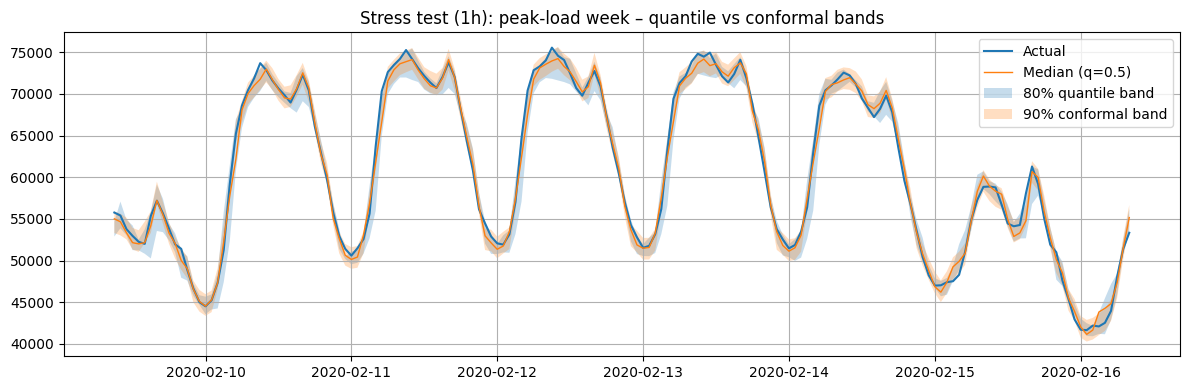

In [20]:
# 1h stress test: peak-load week plot
peak_idx_1h = int(np.argmax(y_test.values))
start_idx_1h = max(0, peak_idx_1h - 3*24)
end_idx_1h = min(len(y_test), peak_idx_1h + 4*24)
sl_1h = slice(start_idx_1h, end_idx_1h)

plt.figure(figsize=(12, 4))
plt.plot(y_test.index[sl_1h], y_test.values[sl_1h], label="Actual", lw=1.5)
plt.plot(y_test.index[sl_1h], median_q[sl_1h], label="Median (q=0.5)", lw=1.0)
plt.fill_between(y_test.index[sl_1h], lower_q[sl_1h], upper_q[sl_1h], alpha=0.25, label="80% quantile band")
plt.fill_between(y_test.index[sl_1h], lower_conf[sl_1h], upper_conf[sl_1h], alpha=0.25, label="90% conformal band")
plt.title("Stress test (1h): peak-load week – quantile vs conformal bands")
plt.legend()
plt.tight_layout()
plt.show()

Around the highest-demand hours, the 80% quantile band is tighter but shows more near-misses at sharp peaks/ramps.  

The 90% conformal band is wider and generally stays over the peak region, matching its stronger extreme-hour coverage.



## Diagnostics by hour of day 

Load uncertainty is not stationary across the day.
We compute coverage and width by hour to identify systematic under/over-coverage
and compare sharpness on a normalized scale (width / median load).


/var/folders/zp/85klwk4938514ydsph5grv3m0000gq/T/ipykernel_61817/470671355.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_hour = df.groupby("hour").apply(


,hour,cov_q80,cov_conf90,width_q80,width_conf90,width_q80_norm,width_conf90_norm
0,0,0.826923,0.997596,1299.012271,2598.045791,0.024315,0.04863
1,1,0.831731,0.983173,1545.108124,2598.045791,0.028921,0.04863
2,2,0.740385,0.887019,2918.632814,2598.045791,0.054631,0.04863
3,3,0.824519,0.610577,6074.054619,2598.045791,0.113694,0.04863
4,4,0.867788,0.721154,6426.590640,2598.045791,0.120293,0.04863
5,5,0.860577,0.776442,3764.992609,2598.045791,0.070473,0.04863
6,6,0.644231,0.685096,2750.023493,2598.045791,0.051475,0.04863
7,7,0.718750,0.699519,2588.274943,2598.045791,0.048447,0.04863
8,8,0.819712,0.713942,2376.853900,2598.045791,0.044490,0.04863
9,9,0.742788,0.793269,1901.007903,2598.045791,0.035583,0.04863


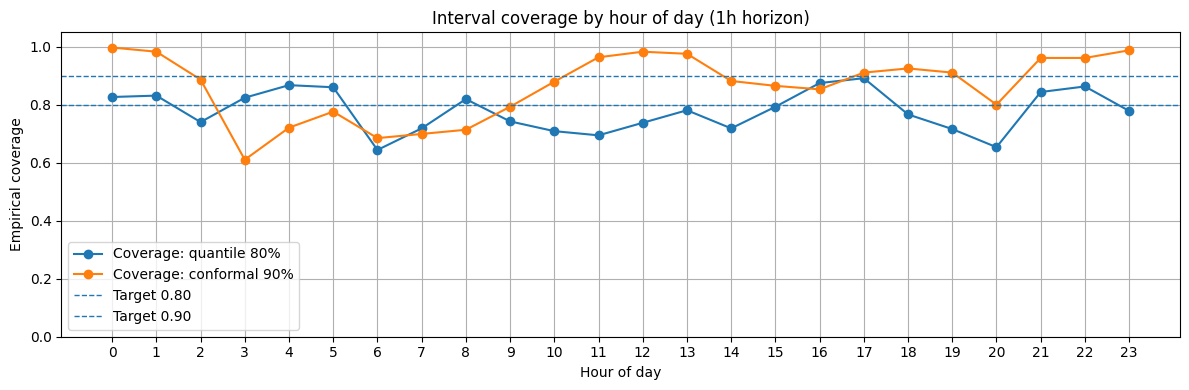

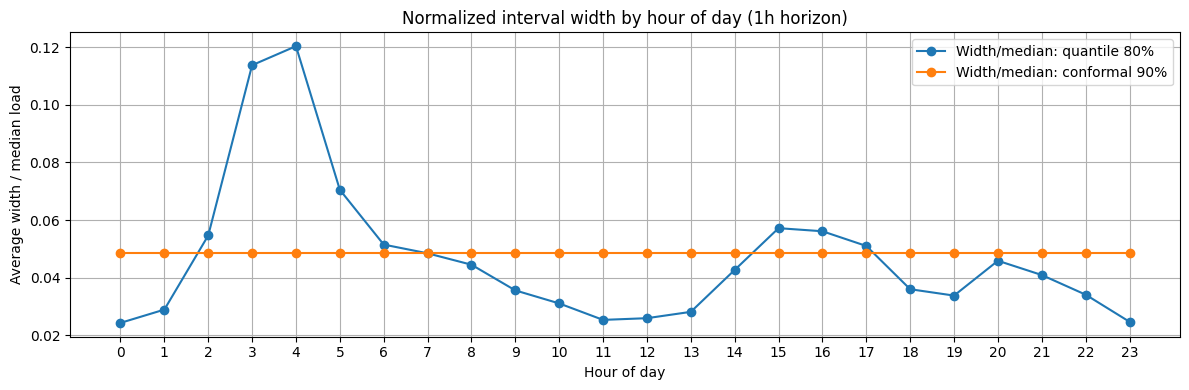

In [ ]:
# Hour index
hour = y_test.index.hour

# Median load for normalization
median_load = float(np.median(y_test.values))

# Build a tidy frame
df = pd.DataFrame({
    "hour": hour,
    "y": y_test.values,
    "q_lower": lower_q,
    "q_upper": upper_q,
    "c_lower": lower_conf,
    "c_upper": upper_conf,
})

# Coverage + width per hour
by_hour = df.groupby("hour").apply(
    lambda g: pd.Series({
        "cov_q80": interval_coverage(g["y"].values, g["q_lower"].values, g["q_upper"].values),
        "cov_conf90": interval_coverage(g["y"].values, g["c_lower"].values, g["c_upper"].values),
        "width_q80": interval_width(g["q_lower"].values, g["q_upper"].values),
        "width_conf90": interval_width(g["c_lower"].values, g["c_upper"].values),
    })
).reset_index()

# Normalized widths
by_hour["width_q80_norm"] = by_hour["width_q80"] / median_load
by_hour["width_conf90_norm"] = by_hour["width_conf90"] / median_load

display(by_hour)

# Coverage by hour
plt.figure(figsize=(12, 4))
plt.plot(by_hour["hour"], by_hour["cov_q80"], marker="o", label="Coverage: quantile 80%")
plt.plot(by_hour["hour"], by_hour["cov_conf90"], marker="o", label="Coverage: conformal 90%")
plt.axhline(0.80, linestyle="--", linewidth=1, label="Target 0.80")
plt.axhline(0.90, linestyle="--", linewidth=1, label="Target 0.90")
plt.xticks(range(0, 24))
plt.ylim(0, 1.05)
plt.title("Interval coverage by hour of day (1h horizon)")
plt.xlabel("Hour of day")
plt.ylabel("Empirical coverage")
plt.legend()
plt.tight_layout()
plt.show()

# Normalized width by hour
plt.figure(figsize=(12, 4))
plt.plot(by_hour["hour"], by_hour["width_q80_norm"], marker="o", label="Width/median: quantile 80%")
plt.plot(by_hour["hour"], by_hour["width_conf90_norm"], marker="o", label="Width/median: conformal 90%")
plt.xticks(range(0, 24))
plt.title("Normalized interval width by hour of day (1h horizon)")
plt.xlabel("Hour of day")
plt.ylabel("Average width / median load")
plt.legend()
plt.tight_layout()
plt.show()


Coverage varies substantially across the day, showing that forecast uncertainty is not stationary.

- Quantile 80%: coverage drops below the 0.80 target in several hours (notably early morning and evening), indicating undercoverage during specific regimes.
- Conformal 90%: coverage is generally closer to (and often above) 0.90, but dips in a few early-morning hours, which is evidence that a single global residual scale is still imperfect under regime shifts.

Normalized width highlights the main difference in how the two methods represent uncertainty:

- Conformal width is nearly flat by hour (expected for basic residual conformal using one calibration quantile).
- Quantile width changes a lot by hour, with much wider bands in the early morning hours, suggesting the quantile model is capturing time-varying heteroskedasticity, though not always translating that into correct coverage.

**Takeaway:** error behavior depends on hour-of-day; a natural next step is hour-conditioned uncertainty (e.g., grouped/rolling conformal by hour, or richer features) to improve calibration in the hours that systematically under-cover.

## Notes and next steps

Current runs use time-series + calendar feature engineering; weather predictors are not included.
If temperature becomes available, it’s a high-leverage addition for both point accuracy and calibration.

Notebook 05 extends the same probabilistic workflow to 24-hour-ahead forecasting,
where uncertainty increases and regime shifts become more challenging.
